In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
# from scipy import *
# from numpy import *
# for finding k eigen values
import scipy.sparse.linalg

In [2]:
def calculateErr(T, Y):
    vT = (T >= 0);
    vY = (Y >= 0);
    err = sum(vT != vY)/size(Y);
    return err


In [12]:
def MixGauss(means, sigmas, n):
    numRowsOfMeans = means.shape[0];
    numColsOfMeans = means.shape[1];
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    X = []
    Y = []
    for i in range(numColsOfMeans):
        meansOfColumnI = means[:, i]
        sigmaOfI = sigmas[i]
        Xi = zeros((n, numRowsOfMeans))
        Yi = zeros((n, 1))
        
        for j in range(n):
            x = sigmaOfI * random.randn(numRowsOfMeans, 1) + meansOfColumnI
            Xi[j, :] = squeeze(asarray(x))
            Yi[j] = i+1
            
#         tempXi = Xi
#         tempYi = Yi
            
        X.append(Xi)
        Y.append(Yi)
#         X = column_stack(Xi)
#         X = concatenate((Xi, Xi), axis=0)
#         Y = concatenate((Yi, Yi), axis=0)
#         X[0:100,:] = tempXi
#         X[100:200,:] = Xi
#         Y[0:100,:] = tempYi
#         Y[100:200,:] = Yi
    return X, Y
            

In [4]:
def PCA(X, k):
# [V, d, X_proj] = PCA(X, k)
# computes the first k eigenvectors, eigenvalues and projections of the 
# matrix X'*X/n where n is the number of rows in X.
# 
# X is the dataset
# k is the number of components
# 
# V is a matrix of the form [v_1, ..., v_k] where v_i is the i-th
# eigenvector
# d is the list of the first k eigenvalues
# X_proj is the projection of X on the linear space spanned by the
# eigenvectors in V
    
    numRowsOfX = X.shape[0]
    D, V = scipy.sparse.linalg.eigs((X.conj().transpose().dot(X))/numRowsOfX, k)
#     diagonal = diag(D)
    D = D * (D > 0)
#     D = sorted(D, reverse = True)
    D[::-1].sort()
    I = D.argsort()
    V = V[:, I]
    X_proj = X.dot(V)
    
    return V, D, X_proj

In [5]:
def OMatchingPursuit(X, Y, T):

    N, D = shape(X)
    
    # Initialization of residual, coefficient vector and index set I
    r = Y
    w = zeros((D, 1))
    I = []
    
    for i in range(T-1):
        I_tmp = list(range(D))
        
        ### Select the column of X which most "explains" the residual
        a_max = -1
        
        for j in I_tmp:
#             a_tmp = ((residual.T * X[:,1])**2)/(X[:,1].T * X[:,1])
            a_tmp = ((r.T.dot(X[:,j]))**2)/(X[:,j].T.dot(X[:,j]))
#             a_tmp = dot(residual.T, inputData[:])
            
            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j
                
        # Add the index to the set of indexes
        if sum(I == j_max) == 0:
            I.append(j_max)
            
        # Compute the M matrix
        M_I = zeros((D,D))
                    
        for j in I:
            M_I[j,j] = 1
                   
        A = M_I.dot(X.T).dot(X).dot(M_I)
#         A = dot((dot(dot(M_I, X.T), X)), M_I)
        B = M_I.dot(X.T).dot(Y)
#         B = dot((dot(M_I, X.T)), Y)
        
        # Update estimated coefficients
        w = linalg.pinv(A).dot(B)
        
        # Update the residual
        r = Y - X.dot(w)
#         residual = outputLabel - dot(inputData, estimatedCoeff)
        
    return w, r, I
 

In [6]:
def holdoutCVOMP(X, Y, perc, nrip, intIter):
    nIter = size(intIter)
    
    n = X.shape[0]
    ntr = int(ceil(n*(1-perc)))
        
    tmn = zeros((nIter, nrip))
    vmn = zeros((nIter, nrip))
    
    for rip in range(nrip):
        I = random.permutation(n)
        Xtr = X[I[:ntr],:]
        Ytr = Y[I[:ntr],:]
        Xvl = X[I[ntr:],:]
        Yvl = Y[I[ntr:],:]
        
        iit = -1
        
        newIntIter = [x+1 for x in intIter]
        for it in newIntIter:
            iit = iit + 1;
            w, r, I = OMatchingPursuit(Xtr, Ytr, it)
            tmn[iit, rip] = calcErr(Xtr.dot(w),Ytr)
            vmn[iit, rip] = calcErr(Xvl.dot(w),Yvl)
            
#             print(('rip\\tIter\\tvalErr\\ttrErr\\n%d\\t%d\\t%f\\t%f\\n'), rip, it, vmn(iit, rip), tmn(iit, rip))
            
    Tm = median(tmn,axis=1);
    Ts = std(tmn,axis=1);
    Vm = median(vmn,axis=1);
    Vs = std(vmn,axis=1);
    
    # one of the min removed to make it iterable
    row = nonzero(Vm <= min(Vm));
    # added to solve last index problem
    row = row[0] 
    
    it = intIter[row[0]]
    
    return it, Vm, Vs, Tm, Ts


In [46]:
# X = Xtr
# Y = Ytr
# nIter = size(intIter)
    
# n = X.shape[0]
# ntr = int(ceil(n*(1-perc)))
        
# tmn = zeros((nIter, nrip))
# vmn = zeros((nIter, nrip))
    
# for rip in range(nrip):
#     I = random.permutation(n)
#     Xtr = X[I[:ntr],:]
#     Ytr = Y[I[:ntr],:]
#     Xvl = X[I[ntr:],:]
#     Yvl = Y[I[ntr:],:]
        
#     iit = -1
#     newIntIter = [x+1 for x in intIter] 
#     for it in newIntIter:
#         iit = iit + 1;
#         w, residual, indices = OMatchingPursuit(Xtr, Ytr, it)
#         tmn[iit, rip] =  calculateErr(dot(Xtr,w),Ytr)
#         vmn[iit, rip]  = calculateErr(dot(Xvl,w),Yvl)

In [48]:
# Tm = median(tmn,axis=1);
# Ts = std(tmn,axis=1);
# Vm = median(vmn,axis=1);
# Vs = std(vmn,axis=1)


In [67]:
# row = nonzero(Vm <= min(Vm))
# row = row[0]

In [68]:
# intIter[row[0]]

2

In [46]:
# Tm = median(tmn,axis=1);
# Ts = std(tmn,axis=1);
# Vm = median(vmn,axis=1);
# Vs = std(vmn,axis=1);

In [55]:
# # # row = nonzero(Vm <= min(min(Vm)));
# nonzero(Vm <= min(Vm))

(array([2]),)

In [7]:
def calcErr(T, Y):
    err = mean(sign(T)!=sign(Y));
    return err

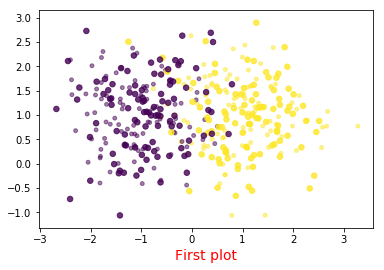

In [13]:
# main1
N = 100;
D = 30;
Xtr, Ytr = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7], [0.7]]),N);
Xtr = concatenate(Xtr, axis=0)
Ytr = concatenate(Ytr, axis=0)
Ytr[Ytr==2]= -1;
Xts, Yts = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7],[0.7]]),N);
Xts = concatenate(Xts, axis=0)
Yts = concatenate(Yts, axis=0)
Yts[Yts==2] = -1;

plt.scatter(Xtr[:,0], Xtr[:,1], s=15, c=Ytr, alpha=0.5)
plt.scatter(Xts[:,0], Xts[:,1], s=30, c=Yts, alpha=0.8)
plt.xlabel('First plot', fontsize=14, color='red')
plt.show()
# plt.title('First plot')

In [21]:
# Xtr.shape

(200, 30)

In [9]:
sigma_noise = 0.01;
# Xtr_noise=sigma_noise*randn(2*N,D-2);
# Xts_noise=sigma_noise*randn(2*N,D-2);
Xtr_noise = sigma_noise*random.randn(2*N, D-2);
Xts_noise = sigma_noise*random.randn(2*N, D-2);

# Xtr =[Xtr, Xtr_noise];
# Xts =[Xts, Xts_noise];
Xtr = concatenate((Xtr, Xtr_noise), axis=1)
Xts = concatenate((Xts, Xts_noise), axis=1)

/home/suraj/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


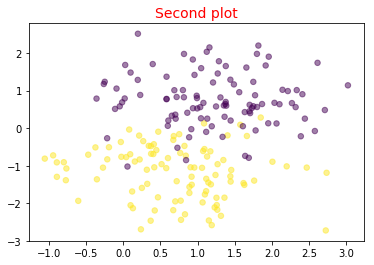

In [10]:
V, d, X_proj = PCA(Xtr, 2)
# scatter(X_proj(:,1), X_proj(:,2), 50, Ytr, 'filled');
plt.scatter(X_proj[:,0], X_proj[:,1], s=30, c=Ytr, alpha=0.5)
plt.title('Second plot', fontsize=14, color='red')
plt.show()

In [18]:
# X_proj[:,0].shape == X_proj[:,1].shape == X_proj[:,2].shape

True

In [11]:
V, d, X_proj = PCA(Xtr, 3)

In [34]:
# Ytr.shape

(200, 1)

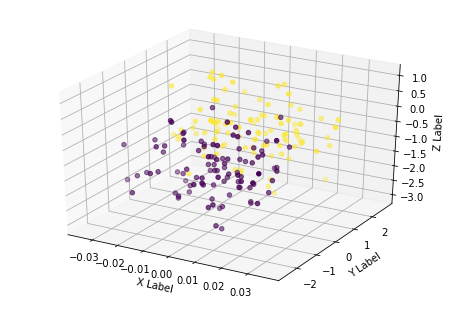

In [12]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
fig = pyplot.figure()
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
x = X_proj[:,0].real
y = X_proj[:,1].real
z = X_proj[:,2].real
# x = [1,2,3,4,5, 6, 7, 8]
# y = [3,4,5,6,2, 9, 3, 2]
# z = [1, 5, 4, 3, 2, 2, 1, 3]
ax.scatter(x, y, z, c=Ytr, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

pyplot.show()

[ 1.25197590+0.j  1.20853079+0.j  0.01353273+0.j]


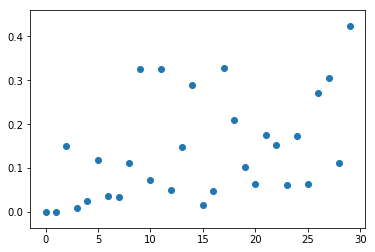

In [13]:
V, d, X_proj = PCA(Xtr, 3);
print(sqrt(d[:10]));

plt.scatter(list(range(D)), abs(V[:,0]))
plt.show()

In [14]:
## Test on different sigma
Xtr, Ytr = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7], [0.7]]),N);
Xtr = concatenate(Xtr, axis=0)
Ytr = concatenate(Ytr, axis=0)
Ytr[Ytr==2]= -1;

Xts, Yts = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7],[0.7]]),N);
Xts = concatenate(Xts, axis=0)
Yts = concatenate(Yts, axis=0)
Yts[Yts==2] = -1;

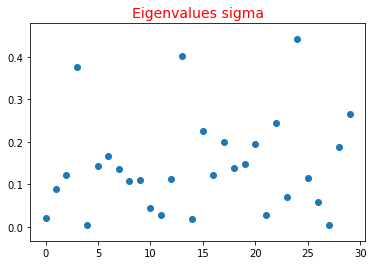

/home/suraj/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


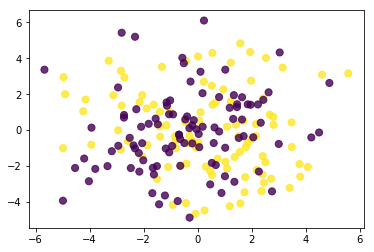

In [15]:
sigma_noise = [0, 0.01, 0.1, 0.5, 0.7, 1, 1.2, 1.4, 1.6, 2]

Xtr_noise = sigma_noise[9]*random.randn(2*N, D-2);

Xtr2 = concatenate((Xtr, Xtr_noise), axis=1)

V, d, X_proj = PCA(Xtr2, 10)

plt.scatter(list(range(D)), abs(V[:,0]));
plt.title('Eigenvalues sigma',fontsize=14, color='red')
plt.show()

plt.scatter(X_proj[:,1], X_proj[:,2], 50, Ytr, alpha=0.8);
plt.show()
## completion of main1
## first plot of eigen values sigma still not matching

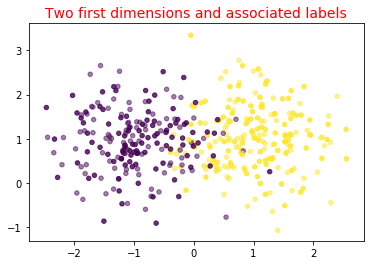

In [16]:
## main2

N = 100
D = 30

Xtr, Ytr = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7], [0.7]]),N);
Xtr = concatenate(Xtr, axis=0)
Ytr = concatenate(Ytr, axis=0)
Ytr[Ytr==2]= -1;

Xts, Yts = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7],[0.7]]),N);
Xts = concatenate(Xts, axis=0)
Yts = concatenate(Yts, axis=0)
Yts[Yts==2] = -1;

plt.scatter(Xtr[:,0], Xtr[:,1], s=20, c=Ytr, alpha=0.5);
plt.scatter(Xts[:,0], Xts[:,1], s=20, c=Yts, alpha=0.8);
plt.title('Two first dimensions and associated labels', fontsize=14, color='red');
plt.show()

In [17]:
sigma_noise = 0.01;
Xtr_noise = sigma_noise * random.randn(2*N, D-2);
Xts_noise = sigma_noise * random.randn(2*N, D-2);

Xtr = concatenate((Xtr, Xtr_noise), axis=1)
Xts = concatenate((Xts, Xts_noise), axis=1)

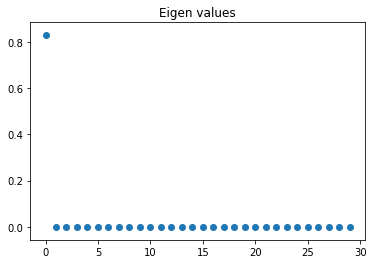

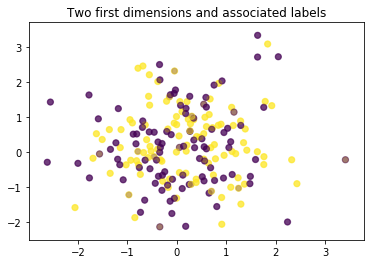

In [18]:
# Normalize

m = mean(Xtr, axis=0)
s = std(Xtr, axis=0)

for i in range(2*N):
    Xtr[i, :] = Xtr[i, :] - m
    Xts[i, :] = Xts[i, :] - m
    
for i in range(2*N):
    Xtr[i, :] = Xtr[i, :] / s
    Xts[i, :] = Xts[i, :] / s
    
w, r, I = OMatchingPursuit(Xtr, Ytr, 2)

Ypred = sign(Xts.dot(w))

err = calcErr(Yts, Ypred);
# figure
plt.scatter(list(range(D)), abs(w))
plt.title('Eigen values');
plt.show()

# figure
plt.scatter(Xts[:,1], Xts[:,2], 30, Yts, alpha=0.5);
# hold on;
plt.scatter(Xts[:,1], Xts[:,2], 40, Ypred, alpha=0.5);
plt.title('Two first dimensions and associated labels', );
plt.show()    

In [19]:
intIter = list(range(D))
perc = 0.75
nrip = 20
it, Vm, Vs, Tm, Ts = holdoutCVOMP(Xtr, Ytr, perc, nrip, intIter)

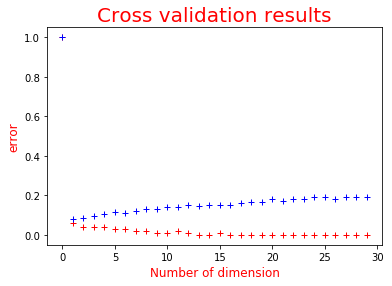

In [20]:
# figure;
plt.plot(intIter, Tm, 'r+');
# hold on;
plt.plot(intIter, Vm, 'b+');
# hold on;
plt.title('Cross validation results', fontsize=20, color='red'); 
# plt.legend('Training error','Validation error'); 
plt.xlabel('Number of dimension', fontsize=12, color='red'); 
plt.ylabel('error', fontsize=12, color='red');
plt.show()

In [5]:
# Xtr = concatenate(Xtr, axis=0)
# Ytr = concatenate(Ytr, axis=0)
# shape(Xtr)

(200, 2)

In [6]:
# Ytr[Ytr==2] = -1

In [7]:
# Xts, Yts = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)
# Xts = concatenate(Xts, axis=0)
# Yts = concatenate(Yts, axis=0)
# shape(Xts)

(200, 2)

In [8]:
# Yts[Yts==2] = -1;

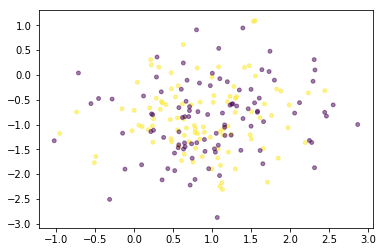

In [9]:
# plt.scatter(Xtr[:,0], Xtr[:,1], s=15, c=Ytr, alpha=0.5)
# plt.show()

In [10]:
# sigma_noise = 0.01;
# N = 100
# D = 30
# Xtr_noise = random.randn(2*N, D-2);
# Xts_noise = sigma_noise*random.randn(2*N,D-2);



1.C The remaining variables will be generated as gaussian noise

In [4]:
# Xtr, Ytr = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)

In [11]:
# Xtr = concatenate(Xtr, Xtr_noise, axis = 1)
# shape(Xtr_noise)

(200, 28)

In [12]:
# Xtr = concatenate((Xtr, Xtr_noise), axis=1)
# Xts = concatenate((Xts, Xts_noise), axis=1)

In [13]:
# Xtr.shape

(200, 30)

In [15]:
# V, D, X_proj = PCA(Xtr, 2)

In [24]:
# from mpl_toolkits.mplot3d import Axes3D
# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')
# Axes3D.scatter(xs=X_proj[:,0], ys=X_proj[:,1], zs=0, zdir='z', s=20, c=Ytr, depthshade=True)

TypeError: scatter() missing 1 required positional argument: 'self'

In [23]:
# type(2)

int

In [41]:
# w, r, I = OMatchingPursuit( Xtr, Ytr, 2)


In [39]:
#  w = OMatchingPursuit(Xtr, Ytr, 2)

In [41]:
# D, V = scipy.sparse.linalg.eigs((X.conj().transpose().dot(X))/numRowsOfX, k)

NameError: name 'X' is not defined